In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl

import time
import sys
%matplotlib inline

In [13]:
from parity_machines.tree_machine import TreeParityMachine

In [14]:
def test_sync(k, n, l, update_rules=['hebbian'], echo=False, max_time=float('inf')):

	A = TreeParityMachine(n, k, l)
	B = TreeParityMachine(n, k, l)
	E = TreeParityMachine(n, k, l)

	def sync_score(m1, m2):
		return 1.0 - np.average(1.0 * np.abs(m1.W - m2.W)/(2 * l))

	sync = False 
	updates = 0
	eve_updates = 0 
	scores = [] 
	eve_scores = []

	ctr=0
	Y = []
	t1 = time.time()
	while(not sync):
		for update_rule in update_rules:

			X = A.generate_input()

			y_A = A.forward(X) 
			y_B = B.forward(X) 
			Y.append((y_A, y_B))
			y_E = E.forward(X) 
			A.update(y_B, update_rule)
			B.update(y_A, update_rule)
			updates += 1

			if y_A == y_B == y_E:
				E.update(y_A, update_rule)
				eve_updates += 1

			A.sync_level(B.get_key())
			score = sync_score(A, B) 
			scores.append(score)
			score_EA = sync_score(A, E)
			score_EB = sync_score(B, E)
			eve_scores.append((score_EA, score_EB))

			if y_A == y_B:
				ctr+=1
			else:
				ctr = 0

			# sync = score == 1
			sync = ctr > n + k + l

			score_format = lambda s: str(int(s * 100))
			if echo:
				sys.stdout.write(f"\rSynchronization(AB, EA, EB) = ({score_format(score)}, {score_format(score_EA)}, {score_format(score_EB)})%   /" \
		     + f"  Updates(AB, EAB)  = ({str(updates)}, {str(eve_updates)})") 
		
		if time.time() - t1 > max_time:
			raise TimeoutError()



	time_taken = time.time() - t1

	if echo:
		if sync:
			print('\nAlice and Bob are synchronized.')
		if eve_scores[-1][0] == 1:
			print('Eve is also synchornized !!!')
	return {'synced': (A.W == B.W).all(),
	  		'time': time_taken,
	    	'updates': updates,
		  	'eve_updates': eve_updates,
		    'alice': A, 'bob': B, 'eve': E,
			'scores': np.array(scores),
			'eve_scores': np.array(eve_scores),
			'Y': Y}


def plot_res(res):
    scores = res['scores']
    eve_scores= res['eve_scores']

    mpl.plot(scores)
    mpl.plot(eve_scores[:, 0])
    mpl.plot(eve_scores[:, 1])
    plt.xlabel('updates')
    plt.ylabel('sync score')
    plt.legend(['Alice/Bob score', 'Eve/Alice score', 'Eve/Bob score'])
    print('Synced: ' + str(res['synced']))


Synchronization(AB, EA, EB) = (100, 67, 67)%   /  Updates(AB, EAB)  = (564, 146)
Alice and Bob are synchronized.
Synced: True


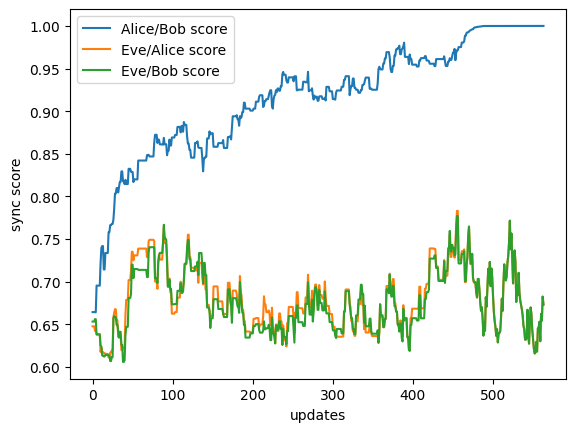

In [15]:
update_rules = ['hebbian', 'anti_hebbian', 'random_walk']
res = test_sync(k=20, n=30, l=30, update_rules=update_rules, echo=True, max_time=55)
plot_res(res)

In [16]:
ctr = 0
correct = 0
nc = []
D = (10, 30)
iters = 10
mi = iters * (D[1] - D[0]) ** 3
for k in range(10, 20):
    for n in range(k + 10, k + 30):
        for l in range(*D):
            for _ in range(iters):
                ctr += 1
                res = test_sync(k=k, n=n, l=l, update_rules=['hebbian'], echo=False, max_time=55)
                synced = res['synced']
                correct += synced
                if not synced:
                    print(f'oops!!!: {len(nc)}\n')
                    nc.append((k,n,l))
                sys.stdout.write(f"\r {ctr} / {mi}")



 411 / 80000oops!!!: 0

 415 / 80000oops!!!: 1

 618 / 80000oops!!!: 2

 722 / 80000oops!!!: 3

 892 / 80000oops!!!: 4

 1009 / 80000oops!!!: 5

 1113 / 80000oops!!!: 6

 1228 / 80000oops!!!: 7

 1258 / 80000oops!!!: 8

 1829 / 80000oops!!!: 9

 3009 / 80000oops!!!: 10

 3058 / 80000oops!!!: 11

 3690 / 80000oops!!!: 12

 4115 / 80000oops!!!: 13

 4406 / 80000oops!!!: 14

 4423 / 80000oops!!!: 15

 4479 / 80000oops!!!: 16

 4612 / 80000oops!!!: 17

 4620 / 80000oops!!!: 18

 4834 / 80000oops!!!: 19

 5015 / 80000oops!!!: 20

 5244 / 80000oops!!!: 21

 5443 / 80000oops!!!: 22

 5643 / 80000oops!!!: 23

 5795 / 80000oops!!!: 24

 6204 / 80000oops!!!: 25

 6205 / 80000oops!!!: 26

 6226 / 80000oops!!!: 27

 7383 / 80000

In [ ]:
alice = res['alice']
bob = res['bob']
eve = res['eve']